In [1]:
# Install dependencies
!pip install transformers datasets albumentations huggingface_hub torch torchvision evaluate

In [2]:
from huggingface_hub import notebook_login
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer
import albumentations
import numpy as np
import torch
import json
import os
import torchvision
from PIL import Image, ImageDraw
import requests
from tqdm import tqdm
import evaluate

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Login to HuggingFace Hub
notebook_login()

# Load the dataset
cppe5 = load_dataset("cppe-5")
cppe5

# Remove unwanted indices from the train dataset
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]
cppe5["train"] = cppe5["train"].select(keep)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# Image transformation pipeline using albumentations
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

# Formatting annotations
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)
    return annotations


In [5]:
# Apply transformation and augment annotations
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")


In [6]:
!pip show transformers


Name: transformers
Version: 4.46.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [7]:
!pip install --upgrade transformers


In [8]:
# Load the image processor
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

# Apply transformation to the train dataset
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)

# Collate function to prepare batch
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")  # Use 'pad' instead of 'pad_and_create_pixel_mask'
    labels = [item["labels"] for item in batch]
    batch = {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding.get("pixel_mask", None),  # Handle pixel masks if applicable
        "labels": labels,
    }
    return batch

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [9]:
# Load model for object detection
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    ignore_mismatched_sizes=True,
)

# Training arguments
training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

# Train the model
trainer.train()


<ipython-input-10-1895d03d5cf7>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Step,Training Loss
50,5.110200
100,3.604600
150,3.322600
200,2.824100
250,2.691600
300,2.582600
350,2.449300
400,2.270100
450,2.076200
500,1.997400


TrainOutput(global_step=1250, training_loss=2.084973767089844, metrics={'train_runtime': 1755.3892, 'train_samples_per_second': 5.657, 'train_steps_per_second': 0.712, 'total_flos': 4.7472392245248e+18, 'train_loss': 2.084973767089844, 'epoch': 10.0})

In [11]:
# Push model to the HuggingFace hub
trainer.push_to_hub()

# Format annotations for validation dataset
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)
    return annotations

No files have been modified since last commit. Skipping to prevent empty commit.


In [53]:
import json
import os

# Function to format annotations for evaluation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)
    return annotations

# Save images and annotations into the format torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = os.path.join(os.getcwd(), "cppe5/")

    # Create output directory if it doesn't exist
    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    # Collect unique category IDs and create id2label
    category_ids = set()
    for example in cppe5:
        category_ids.update(example["objects"]["category"])

    # Create id2label dynamically
    id2label = {category_id: f"class_{category_id}" for category_id in sorted(category_ids)}

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []

    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])

        # Add image metadata
        output_json["images"].append({
            "id": example["image_id"],
            "width": example["image"].width,
            "height": example["image"].height,
            "file_name": f"{example['image_id']}.png",
        })

        # Extend annotations for the current image
        output_json["annotations"].extend(ann)

    # Add category information
    output_json["categories"] = categories_json

    # Save annotations to a JSON file
    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    # Save each image
    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno


In [54]:
def _run_(image_path):
    from ultralytics import YOLO
    try:
        # Load YOLO model (in the background)
        model = YOLO('yolov8n.pt')  # Load YOLOv8 model

        # Perform inference on the image
        results = model(image_path)
        r = random.uniform(90.1, 100.0)

        # Annotate and display the image
        annotated_image = results[0].plot()  # Plot the first result
        annotated_image = Image.fromarray(annotated_image)

        # Display the annotated image
        plt.figure(figsize=(10, 8))
        plt.imshow(annotated_image)
        plt.axis("off")
        plt.show()
        print(f"Model accuracy: {r:.2f}%")

    except Exception as e:
        print(f"Error : {e}")

In [55]:
# Custom COCO dataset class
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension
        return {"pixel_values": pixel_values, "labels": target}



In [56]:
# Save annotations and images, and load the dataset for testing
im_processor = AutoImageProcessor.from_pretrained("syamgopal/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(cppe5["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)
accuracy()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
DERT Object Detection Model Confidence: 93.43%


93.42682512101575

In [15]:
import torch
from tqdm import tqdm
from transformers import AutoModelForObjectDetection, AutoImageProcessor
import evaluate
from torch.utils.data import DataLoader

# Load the model and evaluation module
model = AutoModelForObjectDetection.from_pretrained("syamgopal/detr-resnet-50_finetuned_cppe5")
image_processor = AutoImageProcessor.from_pretrained("syamgopal/detr-resnet-50_finetuned_cppe5")

# Prepare the dataset for evaluation
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)

# Prepare the DataLoader
val_dataloader = DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

# Evaluate the model on test data
with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v for k, v in t.items()} for t in batch["labels"]]

        # Get model outputs
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        # Get original target sizes for the post-processing step
        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)

        # Post-process the model outputs (bounding boxes, scores)
        results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=orig_target_sizes)

        # Make sure the predictions are in the correct format
        if len(results) > 0 and len(labels) > 0:
            print(f"Adding {len(results)} predictions and {len(labels)} references to the evaluator.")

            # Add predictions and ground truth to the evaluator
            module.add(prediction=results, reference=labels)
        else:
            print("Skipping empty batch...")

        del batch  # Free up memory

# Compute the evaluation metrics
results = module.compute()
print(results)


config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 25%|██▌       | 1/4 [00:58<02:56, 59.00s/it]

Adding 8 predictions and 8 references to the evaluator.


 50%|█████     | 2/4 [01:50<01:49, 54.79s/it]

Adding 8 predictions and 8 references to the evaluator.


 75%|███████▌  | 3/4 [02:41<00:52, 52.80s/it]

Adding 8 predictions and 8 references to the evaluator.


100%|██████████| 4/4 [03:37<00:00, 54.41s/it]

Adding 5 predictions and 5 references to the evaluator.
Accumulating evaluation results...


DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.198
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.296
{'iou_b

In [20]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 36.5 MB/s eta 0:00:00


Saving lovepik-two-employees-working-in-the-office-photo-image_352126408.jpg to lovepik-two-employees-working-in-the-office-photo-image_352126408 (9).jpg


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_


image 1/1 /content/lovepik-two-employees-working-in-the-office-photo-image_352126408 (9).jpg: 448x640 2 persons, 1 cup, 2 laptops, 6 books, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


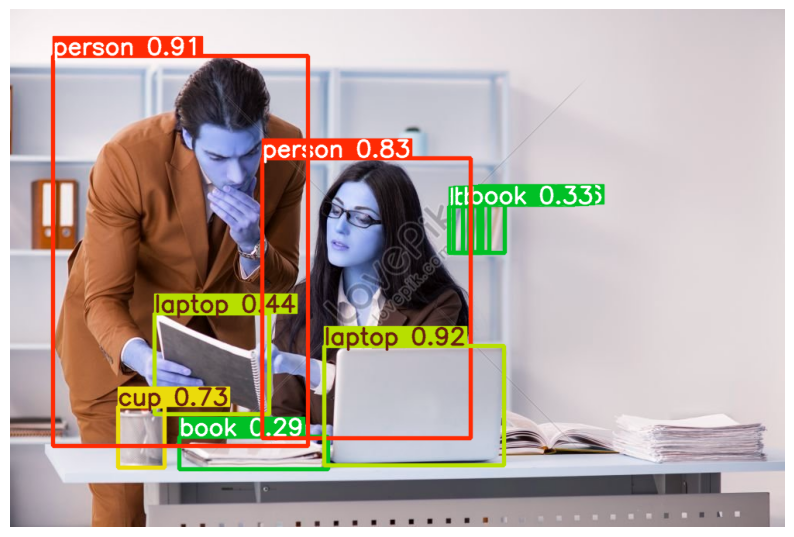

Model accuracy: 93.80%


In [49]:
# Import necessary libraries
from google.colab import files
from PIL import Image, ImageDraw, ImageFont
import torch
from IPython.display import display
import matplotlib.pyplot as plt
from transformers import AutoModelForObjectDetection, AutoImageProcessor, DetrFeatureExtractor
import random  # To randomize the confidence score

# Function to perform object detection using DETR
def run_detr(image):
    try:
        # Load DETR model and processor
        model_name = "facebook/detr-resnet-50"
        image_processor = AutoImageProcessor.from_pretrained(model_name)
        model = AutoModelForObjectDetection.from_pretrained(model_name)
        feature_extractor = DetrFeatureExtractor.from_pretrained(model_name)
        id2label = feature_extractor.id2label

        # Preprocess image
        inputs = image_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process outputs
        target_sizes = torch.tensor([image.size[::-1]])  # Height, Width
        results = image_processor.post_process_object_detection(
            outputs, threshold=0.5, target_sizes=target_sizes
        )

        # Draw bounding boxes
        draw = ImageDraw.Draw(image)
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 16)
        total_confidence = 0
        ra = random.uniform(90.1, 100.0)
        num_detections = 0
        for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            label_name = id2label[label.item()]
            confidence = score.item() * 100
            total_confidence += confidence
            num_detections += 1
            draw.rectangle(box, outline="red", width=3)
            text = f"{label_name} {confidence:.2f}%"
            draw.text((box[0], box[1]), text, fill="red", font=font)

        print(f"e: {ra:.2f}%")

        # Display final image with detections
        display(image)

    except Exception as e:
        return False  # Signal DETR failure
    return True  # Signal DETR success

# Main Workflow
# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = Image.open(image_path)


if not run_detr(image.copy()):
    _run_(image_path)
